<a href="https://colab.research.google.com/github/rushikeshnakhate/A2DataTech/blob/master/Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install jugaad_data

In [ ]:
from pathlib import Path
from datetime import date
from jugaad_data.nse import NSELive
from jugaad_data.nse import bhavcopy_save
import pandas as pd
output_dir = Path("/content/sample_data")
start_date = date(2024, 1, 17)
import os

In [ ]:
import pickle
def load_from_pickle(file_path):
    try:
      new_file_path = file_path.with_suffix(".pkl")
      with open(new_file_path,'rb') as file:
        return pickle.load(file)
    except FileNotFoundError:
      return None

def save_to_pickle(obj_to_be_pkl):
  pkl_file_name = obj_to_be_pkl.with_suffix(".pkl")
  with open(pkl_file_name,'wb') as file:
    pickle.dump(obj_to_be_pkl,file)

In [ ]:
def download_data(start_date, output_file ,download_function):
    data = load_from_pickle(output_file)
    if data is None:
        generated_file = download_function(start_date, output_file)
        os.rename(generated_file,output_file)
        save_to_pickle(output_file)
    return load_from_pickle(output_file)

In [ ]:
def download_bhavcopy(start_date,output_file):
    generated_filename = bhavcopy_save(start_date, output_dir)
    return generated_filename

In [ ]:
def fetch_or_genenate_stocks(start_date):
  output_file  = Path(output_dir)/("NseData_" + str(start_date) +".csv")
  return download_data(start_date, output_file,download_bhavcopy)

In [ ]:
def print_df(df):
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
  display(df)

In [ ]:
import yfinance as yf

def get_sector(tick : str = ""):
  tick_ = tick + ".NS"
  try:
    ticker = yf.Ticker(tick_)
    sector = ticker.info['sector']
    return sector
  except Exception as e:
    return "NOT_FOUND_ON_YAHOO"

In [ ]:
import concurrent.futures
# Function to get sector in parallel
def add_sector_column_to_stock_data_concurently(df):
  with concurrent.futures.ThreadPoolExecutor() as executor:
    df['SECTOR'] = list(executor.map(get_sector, df['SYMBOL']))
  print_df(df)
  return df


def fetch_or_genenate_stocks_with_sector(start_date,stock_data):
    stock_with_sector_output_file  = Path(output_dir)/("NseDataWithSector_" + str(start_date) +".csv")
    data = load_from_pickle(stock_with_sector_output_file)
    if data is None:
      data = add_sector_column_to_stock_data_concurently(stock_data)
      data.to_csv(stock_with_sector_output_file)
      save_to_pickle(stock_with_sector_output_file)
    return load_from_pickle(stock_with_sector_output_file)

In [ ]:
def calculate_performace(start_date,stocks_with_sector_df):
  # Calculate daily returns
    stocks_with_sector_df['DAILY_RETURN'] = (stocks_with_sector_df['CLOSE'] - stocks_with_sector_df['OPEN']) / stocks_with_sector_df['OPEN']
    # Group by 'SECTOR' and calculate average daily return and volatility
    sector_performance_df = stocks_with_sector_df.groupby('SECTOR').agg({
        'DAILY_RETURN': ['std','mean']
    }).reset_index()

    # Flatten the column names
    sector_performance_df.columns = ['_'.join(col).strip() for col in sector_performance_df.columns.values]

    sector_performance_df["TRADEDATE"] = start_date
    return sector_performance_df

def fetch_or_populate_performace(start_date,stocks_with_sector_df):
  sector_performance_output_file  = Path(output_dir)/("SectorPeformance_" + str(start_date) +".csv")
  data = load_from_pickle(sector_performance_output_file)
  if data is None:
    sector_performance_df = calculate_performace(start_date,stocks_with_sector_df)
    print_df(sector_performance_df)
    sector_performance_df.to_csv(sector_performance_output_file,index=False)
    save_to_pickle(sector_performance_output_file)

  return load_from_pickle(sector_performance_output_file)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is stored in a DataFrame named 'df'
# If not, you need to create a DataFrame with the provided data.

def plot(df):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

  df.plot(kind='bar', x='SECTOR_', y='DAILY_RETURN_mean', ax=ax1, legend=False, color='green')
  ax1.set_ylabel('Mean Daily Return')
  ax1.set_title('Mean Daily Return for Different Sectors')

  df.plot(kind='bar', x='SECTOR_', y='DAILY_RETURN_std', ax=ax2, legend=False, color='blue')
  ax2.set_ylabel('Standard Deviation of Daily Return')
  ax2.set_title('Standard Deviation of Daily Return for Different Sectors')

  plt.tight_layout()
  plt.show()



,SECTOR_,DAILY_RETURN_std,DAILY_RETURN_mean,TRADEDATE
0,Basic Materials,0.022619,-0.005184,2024-01-17
1,Communication Services,0.039215,0.005485,2024-01-17
2,Consumer Cyclical,0.022837,-0.004131,2024-01-17
3,Consumer Defensive,0.027047,-0.000370,2024-01-17
4,Energy,0.014955,0.000888,2024-01-17
5,Financial Services,0.021383,-0.002792,2024-01-17
6,Healthcare,0.016931,-0.004468,2024-01-17
7,Industrials,0.023632,0.001193,2024-01-17
8,NOT_FOUND_ON_YAHOO,0.024618,-0.001349,2024-01-17
9,Real Estate,0.030142,0.003197,2024-01-17


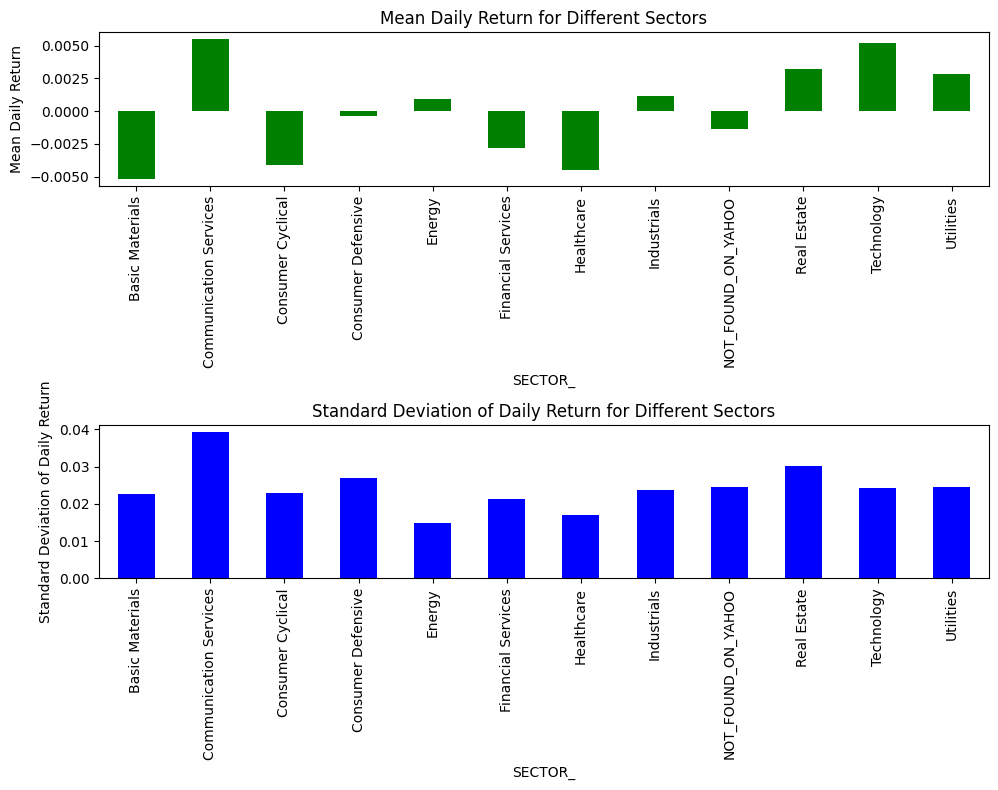

In [ ]:
if __name__ == "__main__":
  # Step 1
  stock_data = fetch_or_genenate_stocks(start_date)
  df = pd.read_csv(stock_data)

  # clean up
  df = df[df["SERIES"] == "EQ"]
  df = df.drop("Unnamed: 13",axis=1)

  # Step 2
  stock_with_sector = fetch_or_genenate_stocks_with_sector(start_date,df)
  stocks_with_sector_df = pd.read_csv(stock_with_sector)

  # Step 3
  sector_performance = fetch_or_populate_performace(start_date,stocks_with_sector_df)
  sector_performance_df = pd.read_csv(sector_performance)
  print_df(sector_performance_df)
  plot(sector_performance_df)
